# Neural integration for constitutive equations 

### Benchmark: elasto-plastic material

Authors: Filippo Masi, Itai Einav

For more, visit: https://github.com/filippo-masi/NICE


### 1. Import libraries

In [1]:
import pickle
import numpy as np
import torch
from scipy.optimize import root
! pip install torchdiffeq
from torchdiffeq import odeint
from NICE_module.ideal_learning import NICE, slice_data, get_params

np.random.seed(6)
torch.manual_seed(6)

# plotting
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('classic')
plt.rcParams.update({"axes.grid" : False, "grid.color": 'black', "grid.alpha":0.4})
font = {'size'   : 11}
matplotlib.rc('font', **font)
plt.rcParams['axes.facecolor']='none'
plt.rcParams['savefig.facecolor']='none'
plt.rcParams['figure.facecolor']='none'
plt.rcParams["figure.figsize"] = (2.5,2)
plt.tight_layout(pad=2.5, w_pad=3.5, h_pad=3.5)
colorb = (0.2,0.4,0.7)

/root/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm

[notice] A new release of pip is available: 23.0.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


<Figure size 200x160 with 0 Axes>

#### 1.1 Set hyperparameters

In [2]:
# Setting the frequency in epochs for printing loss during training
verbose_frequency = 10
plotting_verbose_frequency = 100

# Step size for the training process. If set to 20, it reproduces the original results
# otherwise, set to 1 for faster training.
step_size = 1

# Checking for GPU availability and assigning the device accordingly
device = torch.device('cuda:' + str(gpu) if torch.cuda.is_available() else 'cpu')

# Boolean flag for adding normally distributed noise to the training dataset
corrupted_training_data = False

# If corrupted_training_data is True, set the noise amplitude (percentage)
delta = 0.  # Noise amplitude (percentage) if corrupted_training_data is True

### 2. Import and prepare data sets

In [3]:

# File path for the training dataset
file = './dataset/ideal/benchmark1_data_training'

# Loading data from the specified file using pickle
with open(file, 'rb') as f_obj:
    data = pickle.load(f_obj)

# Unpacking data into individual variables
[strain_t,strain_tdt,stress_t,dt,n_reset] = data

# Setting batch_time equal to n_reset
batch_time = n_reset

# Setting data_size equal to n_reset
data_size = n_reset

# Dimensionality of the data
dim = 2

# Setting prm_dt as the reciprocal of data_size
prm_dt = 1 / data_size

#### 3.1 Reshape 


In [4]:
dstrain = strain_tdt - strain_t
dstrain/=prm_dt

strain_t = np.reshape(strain_t,(batch_time,-1,dim),order='F')
strain_tdt = np.reshape(strain_tdt,(batch_time,-1,dim),order='F')
dstrain = np.reshape(dstrain,(batch_time,-1,dim),order='F')

stress_t = np.reshape(stress_t,(batch_time,-1,dim),order='F')

data_size = strain_t.shape[0]
number_IC = strain_t.shape[1]

#### 3.2 Split data in training, validation, and test sets 

In [5]:
# Percentage of data to be used for training
train_percentage = 0.65

# Calculating the number of samples for training, validation, and testing
train = int(round(number_IC * train_percentage))
val = int(round(number_IC * 0.5 * (1. - train_percentage)))
test = val

# Printing information about the data split
print("Number of samples: ", number_IC)
print("Training samples: ", train)
print("Validation samples: ", val)
print("Test samples: ", test)
print("Total: ", test + val + train)

Number of samples:  24
Training samples:  16
Validation samples:  4
Test samples:  4
Total:  24


In [6]:
# Creating an array of sequential numbers from 0 to number_IC - 1
n = np.arange(0, number_IC, 1)

# Creating an array of indices and shuffling it
rnd = np.arange(len(n))
np.random.shuffle(rnd)
n = n[rnd]

# Splitting the shuffled indices into training, validation, and test sets
ntrain = n[:train]
cut = len(ntrain)
nval = n[train:]
ntrainval = np.hstack((ntrain, nval))
ntest = n[train + val:]

# Shuffling the indices for training and validation combined set
rnd = np.arange(len(ntrainval))
np.random.shuffle(rnd)

# Splitting the shuffled indices for training and validation sets
ntrain = rnd[:train]
nval = rnd[val:]

In [7]:
# Slicing the strain data into training-validation and test sets
strain_t_tv, strain_t_test = slice_data(strain_t, ntrainval, ntest)

# Slicing the time derivative of strain data into training-validation and test sets
strain_tdt_tv, strain_tdt_test = slice_data(strain_tdt, ntrainval, ntest)

# Slicing the incremental strain data into training-validation and test sets
dstrain_tv, dstrain_test = slice_data(dstrain, ntrainval, ntest)

# Slicing the stress data into training-validation and test sets
stress_t_tv, stress_t_test = slice_data(stress_t, ntrainval, ntest)

In [8]:
# Checking if training data needs to be corrupted with noise
if corrupted_training_data:

    # Generating a stress noise vector
    noise = delta/100 * np.random.normal(0, 1, ((data_size+1, number_IC, dim)))
    
    # Copying the stress data to apply noise
    noise_stress_t = stress_t_tv.copy()
    
    # Adding noise to the stress data
    noise_stress_t[:, :, 0] = np.mean(stress_t_tv[:, :, 0]) * noise[:-1, :, 0]
    noise_stress_t[:, :, 1] = np.mean(stress_t_tv[:, :, 1]) * noise[:-1, :, 1]
    
    # Setting the initial time step to zero
    noise_stress_t[0] *= 0.0
    
    # Adding the noise to the original stress data
    stress_t_tv += noise_stress_t

In [9]:
prm_e = get_params(strain_t_tv).to(device)
prm_de = get_params(dstrain_tv).to(device)
prm_s = get_params(stress_t_tv).to(device)

### 4. Neural integration for constitutive equations

#### 4.1 Construct neural net and set integration scheme

In [10]:
dtype=torch.float64
NNf_params = [2*dim,dim,[6*(2*dim),6*(2*dim),6*(2*dim),],'gelu']
NNu_params = [2,1,[2**6,2**6],'softplus']
norm_params = [prm_e,prm_de,prm_s,prm_dt]
nsvars = 1
number_IC = len(ntrainval)
NICE_network = NICE(NNf_params,NNu_params,number_IC,norm_params,dim,dtype).to(device)
NICE_network.to(torch.double)

NICE(
  (NeuralNetEvolution): Sequential(
    (0): Linear(in_features=4, out_features=24, bias=True)
    (1): GELU(approximate=none)
    (2): Linear(in_features=24, out_features=24, bias=True)
    (3): GELU(approximate=none)
    (4): Linear(in_features=24, out_features=24, bias=True)
    (5): GELU(approximate=none)
    (6): Linear(in_features=24, out_features=2, bias=True)
  )
  (NeuralNetEnergy): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Softplus(beta=1, threshold=20)
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
  (relu): ReLU()
)

In [11]:
# Calculating the time step for the simulation
prm_dt = 1 / data_size

# Creating a time array from 0 to 1 with the calculated time step
t = torch.arange(0, 1.0, prm_dt)

# Converting stress and incremental strain data to torch tensors and moving them to the specified device
stress_tv = torch.from_numpy(np.float64(stress_t_tv)).to(device)
dstrain_tv = torch.from_numpy(np.float64(dstrain_tv)).to(device)

# Converting test set stress and incremental strain data to torch tensors and moving them to the specified device
stress_test = torch.from_numpy(np.float64(stress_t_test)).to(device)
dstrain_test = torch.from_numpy(np.float64(dstrain_test)).to(device)

In [12]:
# Setting the solver type for the NICE network
NICE_network.solver = "midpoint"

# Setting the integration scheme for the NICE network
NICE_network.scheme = "forward"

# Setting the step size for the integration in the NICE network
NICE_network.step_size = prm_dt / step_size

# Initializing the interpolation function for incremental strain and time in the NICE network
NICE_network.init_interp(dstrain_tv, t)

# Turning off the inference mode in the NICE network
NICE_network.inference = False

#### 4.2 Training

In [15]:
# Setting the learning rate for the optimizer
learningRate = 1e-2

# Initializing the Adam optimizer with the NICE network parameters
optimizer = torch.optim.Adam(NICE_network.parameters(), lr=learningRate)

# Setting up a learning rate scheduler to adjust the learning rate during training
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)

# L2 penalty weight for regularization
w_reg = 1.e-5

# Number of training epochs
Nepochs = 3000

# Mean Squared Error (MSE) loss function
MSE = torch.nn.MSELoss()

# Lists for storing training and validation loss history
training_loss_hist = []
validation_loss_value_hist = []

In [17]:
import matplotlib

c = 1e+3
def plot(pred,y_tv,ntrain):
    fig1, ax1 = plt.subplots(figsize=(4,3.))
    x = len(pred[:,0])
    ax1.margins(x=0.1, y = 0.1)
    ax1.plot(y_tv[:x,nval,0].cpu().numpy()/c,y_tv[:x,nval,1].cpu().numpy()/c,
             alpha=0.2,linewidth=4,markersize=0.,marker='o',color='black',linestyle='-')
    ax1.plot(pred[:,nval,0].cpu().numpy()/c,pred[:,nval,1].cpu().numpy()/c,
             color='r',alpha=1,linewidth=2)
    ax1.plot(y_tv[:x,ntrain,0].cpu().numpy()/c,y_tv[:x,ntrain,1].cpu().numpy()/c,
             alpha=0.2,linewidth=4,markersize=0.,marker='o',color='black',linestyle='-')
    ax1.plot(pred[:,ntrain,0].cpu().numpy()/c,pred[:,ntrain,1].cpu().numpy()/c,
             color='b',alpha=1,linewidth=2)
    ax1.set_xlabel("$p$ (MPa)")
    ax1.set_ylabel("$q$ (MPa)")
    fig1.tight_layout()
    ax1.grid()
    plt.show() 
    return 

Epoch: 10 | training loss: 2.2952e+00 | validation loss: 1.6470e+00
Epoch: 20 | training loss: 1.4220e+00 | validation loss: 8.5999e-01
Epoch: 30 | training loss: 8.3988e-01 | validation loss: 5.7222e-01
Epoch: 40 | training loss: 4.3352e-01 | validation loss: 3.1295e-01
Epoch: 50 | training loss: 2.8144e-01 | validation loss: 2.3647e-01
Epoch: 60 | training loss: 1.9085e-01 | validation loss: 1.6796e-01
Epoch: 70 | training loss: 1.4506e-01 | validation loss: 1.4079e-01
Epoch: 80 | training loss: 1.1575e-01 | validation loss: 1.1622e-01
Epoch: 90 | training loss: 9.5974e-02 | validation loss: 1.0124e-01
Epoch: 100 | training loss: 7.3387e-02 | validation loss: 7.1976e-02


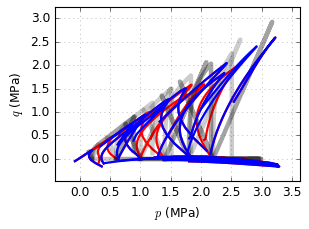

Epoch: 110 | training loss: 5.9789e-02 | validation loss: 5.8905e-02
Epoch: 120 | training loss: 4.6992e-02 | validation loss: 4.7063e-02
Epoch: 130 | training loss: 3.3606e-02 | validation loss: 3.5233e-02
Epoch: 140 | training loss: 2.3779e-02 | validation loss: 2.5682e-02
Epoch: 150 | training loss: 1.7076e-02 | validation loss: 1.9488e-02
Epoch: 160 | training loss: 1.3373e-02 | validation loss: 1.5813e-02
Epoch: 170 | training loss: 1.1062e-02 | validation loss: 1.3520e-02
Epoch: 180 | training loss: 9.3598e-03 | validation loss: 1.1581e-02
Epoch: 190 | training loss: 8.0080e-03 | validation loss: 1.0175e-02
Epoch: 200 | training loss: 6.8434e-03 | validation loss: 8.9809e-03


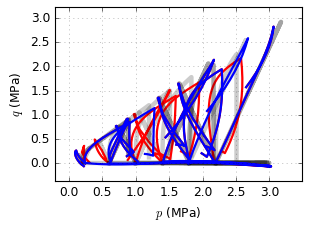

Epoch: 210 | training loss: 5.8998e-03 | validation loss: 7.9658e-03
Epoch: 220 | training loss: 5.1713e-03 | validation loss: 7.1398e-03
Epoch: 230 | training loss: 4.6278e-03 | validation loss: 6.5120e-03
Epoch: 240 | training loss: 4.2275e-03 | validation loss: 6.0440e-03
Epoch: 250 | training loss: 3.9266e-03 | validation loss: 5.6807e-03
Epoch: 260 | training loss: 3.6961e-03 | validation loss: 5.3828e-03
Epoch: 270 | training loss: 3.5139e-03 | validation loss: 5.1314e-03
Epoch: 280 | training loss: 3.3644e-03 | validation loss: 4.9181e-03
Epoch: 290 | training loss: 3.2380e-03 | validation loss: 4.7347e-03
Epoch: 300 | training loss: 3.1284e-03 | validation loss: 4.5720e-03


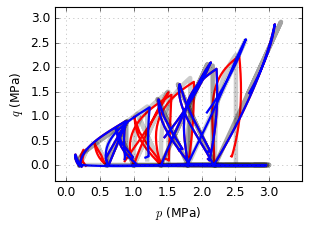

Epoch: 310 | training loss: 3.0314e-03 | validation loss: 4.4240e-03
Epoch: 320 | training loss: 2.9439e-03 | validation loss: 4.2879e-03
Epoch: 330 | training loss: 2.8639e-03 | validation loss: 4.1615e-03
Epoch: 340 | training loss: 2.7900e-03 | validation loss: 4.0434e-03
Epoch: 350 | training loss: 2.7212e-03 | validation loss: 3.9323e-03
Epoch: 360 | training loss: 2.6565e-03 | validation loss: 3.8273e-03
Epoch: 370 | training loss: 2.5953e-03 | validation loss: 3.7276e-03
Epoch: 380 | training loss: 2.5371e-03 | validation loss: 3.6325e-03
Epoch: 390 | training loss: 2.4814e-03 | validation loss: 3.5414e-03
Epoch: 400 | training loss: 2.4279e-03 | validation loss: 3.4539e-03


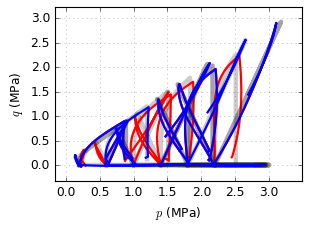

Epoch: 410 | training loss: 2.3763e-03 | validation loss: 3.3695e-03
Epoch: 420 | training loss: 2.3263e-03 | validation loss: 3.2878e-03
Epoch: 430 | training loss: 2.2778e-03 | validation loss: 3.2087e-03
Epoch: 440 | training loss: 2.2308e-03 | validation loss: 3.1319e-03
Epoch: 450 | training loss: 2.1851e-03 | validation loss: 3.0575e-03
Epoch: 460 | training loss: 2.1409e-03 | validation loss: 2.9855e-03
Epoch: 470 | training loss: 2.0982e-03 | validation loss: 2.9160e-03
Epoch: 480 | training loss: 2.0571e-03 | validation loss: 2.8492e-03
Epoch: 490 | training loss: 2.0175e-03 | validation loss: 2.7849e-03
Epoch: 500 | training loss: 1.9793e-03 | validation loss: 2.7230e-03


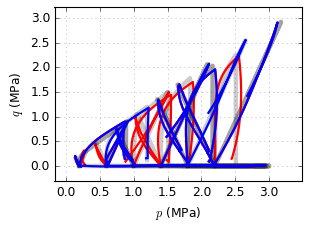

Epoch: 510 | training loss: 1.9425e-03 | validation loss: 2.6636e-03
Epoch: 520 | training loss: 1.9069e-03 | validation loss: 2.6062e-03
Epoch: 530 | training loss: 1.8725e-03 | validation loss: 2.5509e-03
Epoch: 540 | training loss: 1.8391e-03 | validation loss: 2.4965e-03
Epoch: 550 | training loss: 1.8084e-03 | validation loss: 2.4296e-03
Epoch: 560 | training loss: 2.4625e-03 | validation loss: 2.6765e-03
Epoch: 570 | training loss: 2.6561e-03 | validation loss: 3.4971e-03
Epoch: 580 | training loss: 1.8699e-03 | validation loss: 2.5880e-03
Epoch: 590 | training loss: 1.7176e-03 | validation loss: 2.3519e-03
Epoch: 600 | training loss: 1.6670e-03 | validation loss: 2.2489e-03


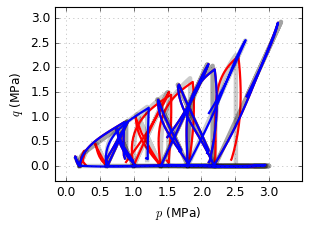

Epoch: 610 | training loss: 1.6372e-03 | validation loss: 2.1867e-03
Epoch: 620 | training loss: 1.6124e-03 | validation loss: 2.1408e-03
Epoch: 630 | training loss: 1.5880e-03 | validation loss: 2.1007e-03
Epoch: 640 | training loss: 1.5636e-03 | validation loss: 2.0658e-03
Epoch: 650 | training loss: 1.5399e-03 | validation loss: 2.0335e-03
Epoch: 660 | training loss: 1.5169e-03 | validation loss: 2.0023e-03
Epoch: 670 | training loss: 1.4945e-03 | validation loss: 1.9709e-03
Epoch: 680 | training loss: 1.4728e-03 | validation loss: 1.9390e-03
Epoch: 690 | training loss: 1.4516e-03 | validation loss: 1.9072e-03
Epoch: 700 | training loss: 1.4309e-03 | validation loss: 1.8762e-03


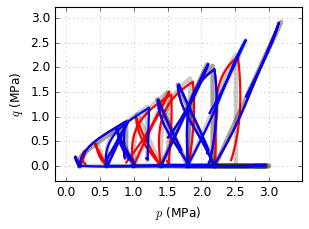

Epoch: 710 | training loss: 1.4107e-03 | validation loss: 1.8465e-03
Epoch: 720 | training loss: 1.3911e-03 | validation loss: 1.8179e-03
Epoch: 730 | training loss: 1.3720e-03 | validation loss: 1.7903e-03
Epoch: 740 | training loss: 1.3533e-03 | validation loss: 1.7634e-03
Epoch: 750 | training loss: 1.3352e-03 | validation loss: 1.7373e-03
Epoch: 760 | training loss: 1.3175e-03 | validation loss: 1.7120e-03
Epoch: 770 | training loss: 1.3002e-03 | validation loss: 1.6875e-03
Epoch: 780 | training loss: 1.2834e-03 | validation loss: 1.6638e-03
Epoch: 790 | training loss: 1.2670e-03 | validation loss: 1.6407e-03
Epoch: 800 | training loss: 1.2510e-03 | validation loss: 1.6183e-03


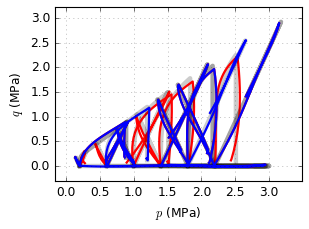

Epoch: 810 | training loss: 1.2355e-03 | validation loss: 1.5966e-03
Epoch: 820 | training loss: 1.2203e-03 | validation loss: 1.5756e-03
Epoch: 830 | training loss: 1.2054e-03 | validation loss: 1.5551e-03
Epoch: 840 | training loss: 1.1910e-03 | validation loss: 1.5352e-03
Epoch: 850 | training loss: 1.1768e-03 | validation loss: 1.5159e-03
Epoch: 860 | training loss: 1.1630e-03 | validation loss: 1.4971e-03
Epoch: 870 | training loss: 1.1495e-03 | validation loss: 1.4788e-03
Epoch: 880 | training loss: 1.1363e-03 | validation loss: 1.4610e-03
Epoch: 890 | training loss: 1.1233e-03 | validation loss: 1.4436e-03
Epoch: 900 | training loss: 1.1107e-03 | validation loss: 1.4266e-03


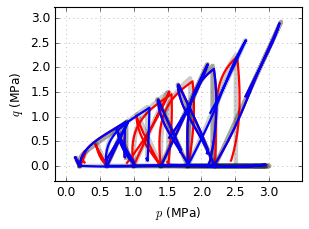

Epoch: 910 | training loss: 1.0983e-03 | validation loss: 1.4101e-03
Epoch: 920 | training loss: 1.0861e-03 | validation loss: 1.3939e-03
Epoch: 930 | training loss: 1.0741e-03 | validation loss: 1.3781e-03
Epoch: 940 | training loss: 1.0624e-03 | validation loss: 1.3626e-03
Epoch: 950 | training loss: 1.0509e-03 | validation loss: 1.3475e-03
Epoch: 960 | training loss: 1.0395e-03 | validation loss: 1.3326e-03
Epoch: 970 | training loss: 1.0284e-03 | validation loss: 1.3181e-03
Epoch: 980 | training loss: 1.0174e-03 | validation loss: 1.3039e-03
Epoch: 990 | training loss: 1.0066e-03 | validation loss: 1.2900e-03
Epoch: 1000 | training loss: 9.9598e-04 | validation loss: 1.2763e-03


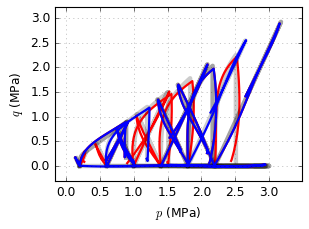

Epoch: 1010 | training loss: 9.8550e-04 | validation loss: 1.2629e-03
Epoch: 1020 | training loss: 9.7517e-04 | validation loss: 1.2497e-03
Epoch: 1030 | training loss: 9.6498e-04 | validation loss: 1.2368e-03
Epoch: 1040 | training loss: 9.5492e-04 | validation loss: 1.2241e-03
Epoch: 1050 | training loss: 9.4500e-04 | validation loss: 1.2116e-03
Epoch: 1060 | training loss: 9.3521e-04 | validation loss: 1.1993e-03
Epoch: 1070 | training loss: 9.2554e-04 | validation loss: 1.1873e-03
Epoch: 1080 | training loss: 9.1598e-04 | validation loss: 1.1755e-03
Epoch: 1090 | training loss: 9.0655e-04 | validation loss: 1.1638e-03
Epoch: 1100 | training loss: 8.9723e-04 | validation loss: 1.1524e-03


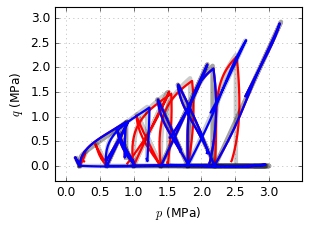

Epoch: 1110 | training loss: 8.8802e-04 | validation loss: 1.1412e-03
Epoch: 1120 | training loss: 8.7892e-04 | validation loss: 1.1301e-03
Epoch: 1130 | training loss: 8.6993e-04 | validation loss: 1.1192e-03
Epoch: 1140 | training loss: 8.6104e-04 | validation loss: 1.1086e-03
Epoch: 1150 | training loss: 8.5225e-04 | validation loss: 1.0980e-03
Epoch: 1160 | training loss: 8.4357e-04 | validation loss: 1.0877e-03
Epoch: 1170 | training loss: 8.3499e-04 | validation loss: 1.0775e-03
Epoch: 1180 | training loss: 8.2652e-04 | validation loss: 1.0675e-03
Epoch: 1190 | training loss: 8.1816e-04 | validation loss: 1.0578e-03
Epoch: 1200 | training loss: 8.0991e-04 | validation loss: 1.0481e-03


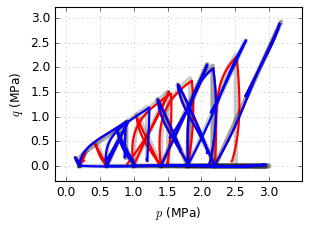

Epoch: 1210 | training loss: 8.0176e-04 | validation loss: 1.0387e-03
Epoch: 1220 | training loss: 7.9371e-04 | validation loss: 1.0294e-03
Epoch: 1230 | training loss: 7.8577e-04 | validation loss: 1.0204e-03
Epoch: 1240 | training loss: 7.7792e-04 | validation loss: 1.0114e-03
Epoch: 1250 | training loss: 7.7018e-04 | validation loss: 1.0027e-03
Epoch: 1260 | training loss: 7.6253e-04 | validation loss: 9.9409e-04
Epoch: 1270 | training loss: 7.5498e-04 | validation loss: 9.8565e-04
Epoch: 1280 | training loss: 7.4752e-04 | validation loss: 9.7738e-04
Epoch: 1290 | training loss: 7.4016e-04 | validation loss: 9.6926e-04
Epoch: 1300 | training loss: 7.3289e-04 | validation loss: 9.6130e-04


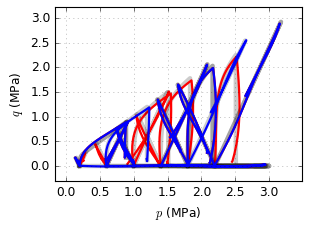

Epoch: 1310 | training loss: 7.2571e-04 | validation loss: 9.5350e-04
Epoch: 1320 | training loss: 7.1862e-04 | validation loss: 9.4586e-04
Epoch: 1330 | training loss: 7.1163e-04 | validation loss: 9.3837e-04
Epoch: 1340 | training loss: 7.0474e-04 | validation loss: 9.3105e-04
Epoch: 1350 | training loss: 6.9795e-04 | validation loss: 9.2389e-04
Epoch: 1360 | training loss: 6.9125e-04 | validation loss: 9.1690e-04
Epoch: 1370 | training loss: 6.8466e-04 | validation loss: 9.1006e-04
Epoch: 1380 | training loss: 6.7815e-04 | validation loss: 9.0339e-04
Epoch: 1390 | training loss: 6.7175e-04 | validation loss: 8.9687e-04
Epoch: 1400 | training loss: 6.6544e-04 | validation loss: 8.9051e-04


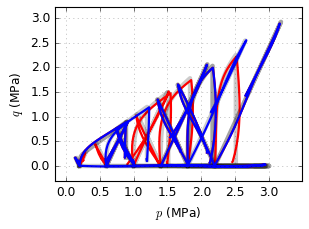

Epoch: 1410 | training loss: 6.5923e-04 | validation loss: 8.8430e-04
Epoch: 1420 | training loss: 6.5311e-04 | validation loss: 8.7824e-04
Epoch: 1430 | training loss: 6.4709e-04 | validation loss: 8.7234e-04
Epoch: 1440 | training loss: 6.4116e-04 | validation loss: 8.6659e-04
Epoch: 1450 | training loss: 6.3534e-04 | validation loss: 8.6099e-04
Epoch: 1460 | training loss: 6.2960e-04 | validation loss: 8.5555e-04
Epoch: 1470 | training loss: 6.2397e-04 | validation loss: 8.5025e-04
Epoch: 1480 | training loss: 6.1843e-04 | validation loss: 8.4511e-04
Epoch: 1490 | training loss: 6.1299e-04 | validation loss: 8.4011e-04
Epoch: 1500 | training loss: 6.0765e-04 | validation loss: 8.3527e-04


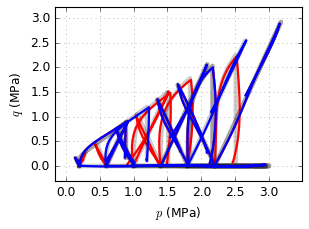

Epoch: 1510 | training loss: 6.0240e-04 | validation loss: 8.3057e-04
Epoch: 1520 | training loss: 5.9725e-04 | validation loss: 8.2602e-04
Epoch: 1530 | training loss: 5.9220e-04 | validation loss: 8.2161e-04
Epoch: 1540 | training loss: 5.8724e-04 | validation loss: 8.1735e-04
Epoch: 1550 | training loss: 5.8238e-04 | validation loss: 8.1324e-04
Epoch: 1560 | training loss: 5.7761e-04 | validation loss: 8.0926e-04
Epoch: 1570 | training loss: 5.7294e-04 | validation loss: 8.0543e-04
Epoch: 1580 | training loss: 5.6836e-04 | validation loss: 8.0173e-04
Epoch: 1590 | training loss: 5.6387e-04 | validation loss: 7.9816e-04
Epoch: 1600 | training loss: 5.5948e-04 | validation loss: 7.9472e-04


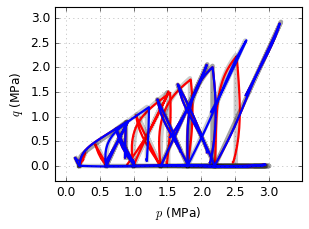

Epoch: 1610 | training loss: 5.5518e-04 | validation loss: 7.9141e-04
Epoch: 1620 | training loss: 5.5097e-04 | validation loss: 7.8823e-04
Epoch: 1630 | training loss: 5.4685e-04 | validation loss: 7.8517e-04
Epoch: 1640 | training loss: 5.4281e-04 | validation loss: 7.8223e-04
Epoch: 1650 | training loss: 5.3887e-04 | validation loss: 7.7940e-04
Epoch: 1660 | training loss: 5.3501e-04 | validation loss: 7.7669e-04
Epoch: 1670 | training loss: 5.3123e-04 | validation loss: 7.7408e-04
Epoch: 1680 | training loss: 5.2754e-04 | validation loss: 7.7158e-04
Epoch: 1690 | training loss: 5.2393e-04 | validation loss: 7.6918e-04
Epoch: 1700 | training loss: 5.2039e-04 | validation loss: 7.6688e-04


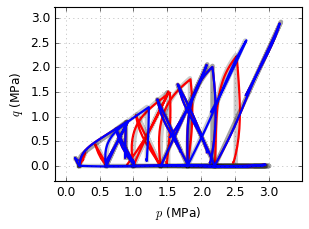

Epoch: 1710 | training loss: 5.1694e-04 | validation loss: 7.6467e-04
Epoch: 1720 | training loss: 5.1356e-04 | validation loss: 7.6255e-04
Epoch: 1730 | training loss: 5.1026e-04 | validation loss: 7.6052e-04
Epoch: 1740 | training loss: 5.0704e-04 | validation loss: 7.5856e-04
Epoch: 1750 | training loss: 5.0388e-04 | validation loss: 7.5669e-04
Epoch: 1760 | training loss: 5.0080e-04 | validation loss: 7.5489e-04
Epoch: 1770 | training loss: 4.9778e-04 | validation loss: 7.5315e-04
Epoch: 1780 | training loss: 4.9483e-04 | validation loss: 7.5147e-04
Epoch: 1790 | training loss: 4.9194e-04 | validation loss: 7.4986e-04
Epoch: 1800 | training loss: 4.8912e-04 | validation loss: 7.4830e-04


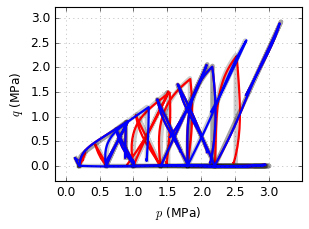

Epoch: 1810 | training loss: 4.8636e-04 | validation loss: 7.4680e-04
Epoch: 1820 | training loss: 4.8365e-04 | validation loss: 7.4536e-04
Epoch: 1830 | training loss: 4.8101e-04 | validation loss: 7.4397e-04
Epoch: 1840 | training loss: 4.7842e-04 | validation loss: 7.4263e-04
Epoch: 1850 | training loss: 4.7588e-04 | validation loss: 7.4134e-04
Epoch: 1860 | training loss: 4.7340e-04 | validation loss: 7.4009e-04
Epoch: 1870 | training loss: 4.7097e-04 | validation loss: 7.3888e-04
Epoch: 1880 | training loss: 4.6860e-04 | validation loss: 7.3771e-04
Epoch: 1890 | training loss: 4.6627e-04 | validation loss: 7.3658e-04
Epoch: 1900 | training loss: 4.6398e-04 | validation loss: 7.3549e-04


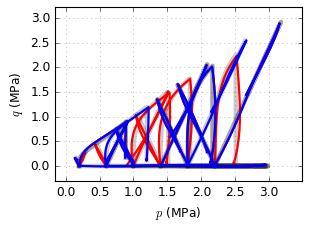

Epoch: 1910 | training loss: 4.6175e-04 | validation loss: 7.3442e-04
Epoch: 1920 | training loss: 4.5956e-04 | validation loss: 7.3339e-04
Epoch: 1930 | training loss: 4.5742e-04 | validation loss: 7.3238e-04
Epoch: 1940 | training loss: 4.5531e-04 | validation loss: 7.3141e-04
Epoch: 1950 | training loss: 4.5325e-04 | validation loss: 7.3045e-04
Epoch: 1960 | training loss: 4.5123e-04 | validation loss: 7.2952e-04
Epoch: 1970 | training loss: 4.4925e-04 | validation loss: 7.2861e-04
Epoch: 1980 | training loss: 4.4730e-04 | validation loss: 7.2771e-04
Epoch: 1990 | training loss: 4.4540e-04 | validation loss: 7.2683e-04
Epoch: 2000 | training loss: 4.4353e-04 | validation loss: 7.2597e-04


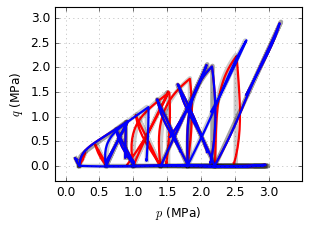

Epoch: 2010 | training loss: 4.4169e-04 | validation loss: 7.2513e-04
Epoch: 2020 | training loss: 4.3989e-04 | validation loss: 7.2430e-04
Epoch: 2030 | training loss: 4.3812e-04 | validation loss: 7.2349e-04
Epoch: 2040 | training loss: 4.3639e-04 | validation loss: 7.2269e-04
Epoch: 2050 | training loss: 4.3468e-04 | validation loss: 7.2190e-04
Epoch: 2060 | training loss: 4.3301e-04 | validation loss: 7.2112e-04
Epoch: 2070 | training loss: 4.3137e-04 | validation loss: 7.2035e-04
Epoch: 2080 | training loss: 4.2975e-04 | validation loss: 7.1960e-04
Epoch: 2090 | training loss: 4.2816e-04 | validation loss: 7.1885e-04
Epoch: 2100 | training loss: 4.2661e-04 | validation loss: 7.1811e-04


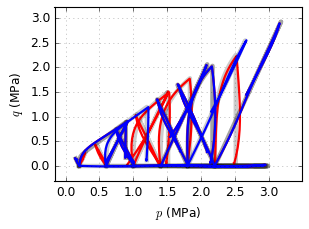

Epoch: 2110 | training loss: 4.2507e-04 | validation loss: 7.1737e-04
Epoch: 2120 | training loss: 4.2357e-04 | validation loss: 7.1665e-04
Epoch: 2130 | training loss: 4.2209e-04 | validation loss: 7.1593e-04
Epoch: 2140 | training loss: 4.2063e-04 | validation loss: 7.1522e-04
Epoch: 2150 | training loss: 4.1920e-04 | validation loss: 7.1451e-04
Epoch: 2160 | training loss: 4.1779e-04 | validation loss: 7.1381e-04
Epoch: 2170 | training loss: 4.1641e-04 | validation loss: 7.1311e-04
Epoch: 2180 | training loss: 4.1504e-04 | validation loss: 7.1242e-04
Epoch: 2190 | training loss: 4.1370e-04 | validation loss: 7.1173e-04
Epoch: 2200 | training loss: 4.1238e-04 | validation loss: 7.1104e-04


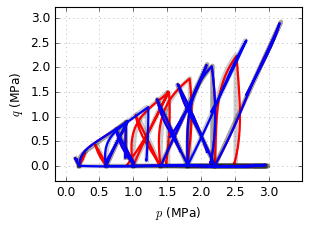

Epoch: 2210 | training loss: 4.1108e-04 | validation loss: 7.1036e-04
Epoch: 2220 | training loss: 4.0981e-04 | validation loss: 7.0968e-04
Epoch: 2230 | training loss: 4.0855e-04 | validation loss: 7.0901e-04
Epoch: 2240 | training loss: 4.0731e-04 | validation loss: 7.0833e-04
Epoch: 2250 | training loss: 4.0608e-04 | validation loss: 7.0766e-04
Epoch: 2260 | training loss: 4.0488e-04 | validation loss: 7.0700e-04
Epoch: 2270 | training loss: 4.0370e-04 | validation loss: 7.0634e-04
Epoch: 2280 | training loss: 4.0253e-04 | validation loss: 7.0567e-04
Epoch: 2290 | training loss: 4.0138e-04 | validation loss: 7.0502e-04
Epoch: 2300 | training loss: 4.0024e-04 | validation loss: 7.0436e-04


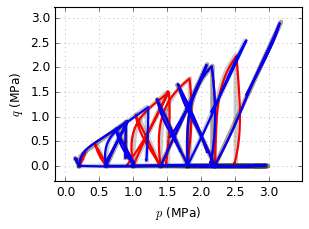

Epoch: 2310 | training loss: 3.9912e-04 | validation loss: 7.0371e-04
Epoch: 2320 | training loss: 3.9802e-04 | validation loss: 7.0306e-04
Epoch: 2330 | training loss: 3.9694e-04 | validation loss: 7.0241e-04
Epoch: 2340 | training loss: 3.9586e-04 | validation loss: 7.0176e-04
Epoch: 2350 | training loss: 3.9481e-04 | validation loss: 7.0112e-04
Epoch: 2360 | training loss: 3.9377e-04 | validation loss: 7.0047e-04
Epoch: 2370 | training loss: 3.9274e-04 | validation loss: 6.9983e-04
Epoch: 2380 | training loss: 3.9172e-04 | validation loss: 6.9919e-04
Epoch: 2390 | training loss: 3.9072e-04 | validation loss: 6.9856e-04
Epoch: 2400 | training loss: 3.8974e-04 | validation loss: 6.9793e-04


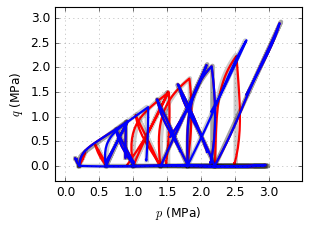

Epoch: 2410 | training loss: 3.8876e-04 | validation loss: 6.9730e-04
Epoch: 2420 | training loss: 3.8780e-04 | validation loss: 6.9667e-04
Epoch: 2430 | training loss: 3.8685e-04 | validation loss: 6.9604e-04
Epoch: 2440 | training loss: 3.8591e-04 | validation loss: 6.9541e-04
Epoch: 2450 | training loss: 3.8498e-04 | validation loss: 6.9479e-04
Epoch: 2460 | training loss: 3.8407e-04 | validation loss: 6.9417e-04
Epoch: 2470 | training loss: 3.8317e-04 | validation loss: 6.9355e-04
Epoch: 2480 | training loss: 3.8227e-04 | validation loss: 6.9293e-04
Epoch: 2490 | training loss: 3.8139e-04 | validation loss: 6.9231e-04
Epoch: 2500 | training loss: 3.8052e-04 | validation loss: 6.9170e-04


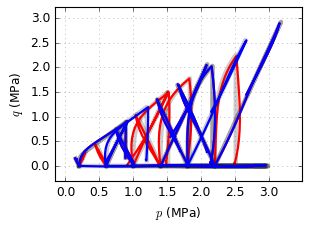

Epoch: 2510 | training loss: 3.7966e-04 | validation loss: 6.9109e-04
Epoch: 2520 | training loss: 3.7881e-04 | validation loss: 6.9048e-04
Epoch: 2530 | training loss: 3.7797e-04 | validation loss: 6.8987e-04
Epoch: 2540 | training loss: 3.7714e-04 | validation loss: 6.8927e-04
Epoch: 2550 | training loss: 3.7632e-04 | validation loss: 6.8867e-04
Epoch: 2560 | training loss: 3.7551e-04 | validation loss: 6.8807e-04
Epoch: 2570 | training loss: 3.7470e-04 | validation loss: 6.8747e-04
Epoch: 2580 | training loss: 3.7391e-04 | validation loss: 6.8687e-04
Epoch: 2590 | training loss: 3.7313e-04 | validation loss: 6.8628e-04
Epoch: 2600 | training loss: 3.7235e-04 | validation loss: 6.8569e-04


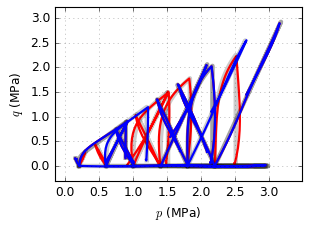

Epoch: 2610 | training loss: 3.7158e-04 | validation loss: 6.8510e-04
Epoch: 2620 | training loss: 3.7082e-04 | validation loss: 6.8452e-04
Epoch: 2630 | training loss: 3.7007e-04 | validation loss: 6.8393e-04
Epoch: 2640 | training loss: 3.6933e-04 | validation loss: 6.8335e-04
Epoch: 2650 | training loss: 3.6860e-04 | validation loss: 6.8277e-04
Epoch: 2660 | training loss: 3.6787e-04 | validation loss: 6.8220e-04
Epoch: 2670 | training loss: 3.6715e-04 | validation loss: 6.8162e-04
Epoch: 2680 | training loss: 3.6644e-04 | validation loss: 6.8105e-04
Epoch: 2690 | training loss: 3.6574e-04 | validation loss: 6.8048e-04
Epoch: 2700 | training loss: 3.6504e-04 | validation loss: 6.7991e-04


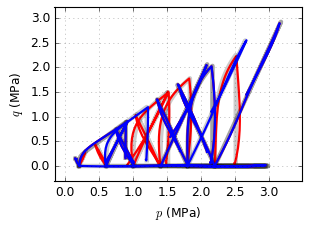

Epoch: 2710 | training loss: 3.6435e-04 | validation loss: 6.7935e-04
Epoch: 2720 | training loss: 3.6367e-04 | validation loss: 6.7878e-04
Epoch: 2730 | training loss: 3.6299e-04 | validation loss: 6.7822e-04
Epoch: 2740 | training loss: 3.6232e-04 | validation loss: 6.7767e-04
Epoch: 2750 | training loss: 3.6166e-04 | validation loss: 6.7711e-04
Epoch: 2760 | training loss: 3.6100e-04 | validation loss: 6.7656e-04
Epoch: 2770 | training loss: 3.6036e-04 | validation loss: 6.7601e-04
Epoch: 2780 | training loss: 3.5971e-04 | validation loss: 6.7546e-04
Epoch: 2790 | training loss: 3.5908e-04 | validation loss: 6.7491e-04
Epoch: 2800 | training loss: 3.5845e-04 | validation loss: 6.7437e-04


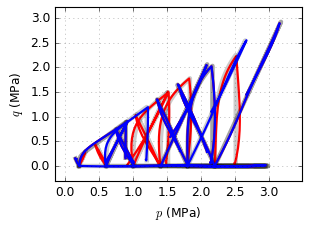

Epoch: 2810 | training loss: 3.5782e-04 | validation loss: 6.7383e-04
Epoch: 2820 | training loss: 3.5720e-04 | validation loss: 6.7329e-04
Epoch: 2830 | training loss: 3.5659e-04 | validation loss: 6.7275e-04
Epoch: 2840 | training loss: 3.5599e-04 | validation loss: 6.7222e-04
Epoch: 2850 | training loss: 3.5539e-04 | validation loss: 6.7169e-04
Epoch: 2860 | training loss: 3.5479e-04 | validation loss: 6.7116e-04
Epoch: 2870 | training loss: 3.5420e-04 | validation loss: 6.7063e-04
Epoch: 2880 | training loss: 3.5362e-04 | validation loss: 6.7011e-04
Epoch: 2890 | training loss: 3.5304e-04 | validation loss: 6.6959e-04
Epoch: 2900 | training loss: 3.5247e-04 | validation loss: 6.6907e-04


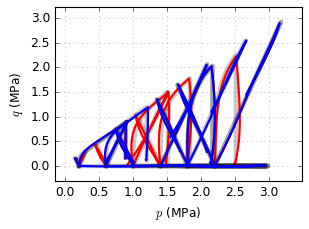

Epoch: 2910 | training loss: 3.5190e-04 | validation loss: 6.6855e-04
Epoch: 2920 | training loss: 3.5133e-04 | validation loss: 6.6804e-04
Epoch: 2930 | training loss: 3.5078e-04 | validation loss: 6.6753e-04
Epoch: 2940 | training loss: 3.5022e-04 | validation loss: 6.6702e-04
Epoch: 2950 | training loss: 3.4968e-04 | validation loss: 6.6651e-04
Epoch: 2960 | training loss: 3.4913e-04 | validation loss: 6.6601e-04
Epoch: 2970 | training loss: 3.4860e-04 | validation loss: 6.6551e-04
Epoch: 2980 | training loss: 3.4806e-04 | validation loss: 6.6501e-04
Epoch: 2990 | training loss: 3.4753e-04 | validation loss: 6.6451e-04


In [19]:
# Training loop
for epoch in range(1, Nepochs):
    # Reset gradients
    optimizer.zero_grad()

    # Compute the residual of the initial stress value based on the initial elastic strain value (hyperparameter)
    ueps_e_0 = NICE_network.DeNormalize(NICE_network.e0, NICE_network.prm_ee)
    stress0 = NICE_network.stress(ueps_e_0)

    # Make predictions
    pred_svars, pred_stress, pred_diss = NICE_network.integrate(dstrain_tv, ueps_e_0, t, np.hstack((ntrain, nval)))

    # Compute training loss
    training_loss_stress = MSE(NICE_network.Normalize(pred_stress[:, ntrain], prm_s),
                               NICE_network.Normalize(stress_tv[:, ntrain], prm_s))
    training_loss_r0 = MSE(NICE_network.Normalize(stress0, prm_s),
                           NICE_network.Normalize(stress_tv[0], prm_s))
    norm_d = torch.max(torch.abs(pred_diss)).detach()
    training_loss_dissipation = MSE(NICE_network.relu(-pred_diss[:, ntrain]) / norm_d,
                                    pred_diss[:, ntrain].detach() * 0)

    # L2 regularization term
    l_reg = torch.tensor(0., requires_grad=True)
    for name, param in NICE_network.named_parameters():
        if 'weight' in name:
            l_reg = l_reg + pow(param, 2).sum()

    # Compute the overall training loss
    training_loss = (torch.mean(training_loss_stress)
                     + torch.mean(training_loss_r0)
                     + torch.mean(training_loss_dissipation)
                     + w_reg * l_reg
                     )

    # Backpropagate loss and perform optimizer step
    training_loss.backward()
    optimizer.step()

    # Learning rate scheduler step
    if scheduler.get_last_lr()[0] > 1.e-4:
        scheduler.step()

    # Compute validation loss
    validation_loss_stress = MSE(NICE_network.Normalize(pred_stress[:, nval], prm_s),
                                 NICE_network.Normalize(stress_tv[:, nval], prm_s))
    validation_loss_dissipation = MSE(NICE_network.relu(-pred_diss[:, nval]) / norm_d,
                                      pred_diss[:, nval].detach() * 0)
    validation_loss = torch.mean(validation_loss_stress) + torch.mean(validation_loss_dissipation)

    # Store loss values
    training_loss_value = training_loss.item()
    validation_loss_value = validation_loss.item()
    training_loss_hist.append(training_loss_value)
    validation_loss_value_hist.append(validation_loss_value)

    # Print loss information
    if not epoch % verbose_frequency:
        print(f"Epoch: {epoch}"
              + f" | training loss: {training_loss_value:.4e}"
              + f" | validation loss: {validation_loss_value:.4e}")
    if not epoch % plotting_verbose_frequency:
        plot(pred_stress.detach(),stress_tv,ntrain)


#### 4.3 Training and validation set evaluation

In [20]:
# Define time array for evaluation
t = prm_dt * torch.linspace(0., data_size - 1, data_size).to(device)

# Get the number of initial conditions
number_IC = stress_tv.shape[1]

# Find initial elastic strain using root finding
initial_elastic_strain = root(NICE_network.find_elastic_strain,
                              args=(stress_tv[0].reshape(-1, 2)),
                              x0=np.zeros((24, 2)),
                              tol=1e-12)

# Convert the result to a torch tensor
eps_e_0 = torch.from_numpy(initial_elastic_strain.x.reshape(-1, 2))

# De-normalize the initial elastic strain
ueps_e_0 = NICE_network.DeNormalize(eps_e_0, NICE_network.prm_ee)

# Inference mode: make predictions
pred_svars, pred_stress, pred_diss = NICE_network.integrate(dstrain_tv, ueps_e_0, t, np.hstack((ntrain, nval)))

# Evaluate the Mean Absolute Error (MAE) for stress
loss = torch.nn.L1Loss()
MAE_stress = loss(NICE_network.Normalize(pred_stress, prm_s), NICE_network.Normalize(stress_tv[:, :, :dim], prm_s))

# Print the MAE for stress
print("MAE stress: ", MAE_stress)

MAE stress:  tensor(0.0158, dtype=torch.float64, grad_fn=<L1LossBackward0>)


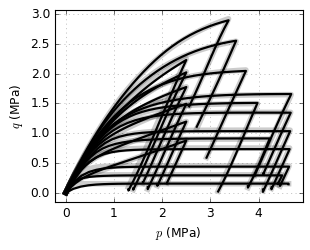

In [21]:
plt.rcParams["figure.figsize"] = (4,3)
fig = plt.figure()
ax = fig.subplots(1)
ax.margins(x=0.05, y = 0.05)
x=-1
for i in np.arange(len(ntrainval)):
    ax.plot(strain_t_tv[:,i,1]*1e+5,stress_tv[:,i,1]/c,alpha=0.2,linewidth=5,color='black',
            markersize=0,marker='.')
    ax.plot(strain_t_tv[:,i,1]*1e+5,pred_stress[:,i,1].detach()/c,alpha=1,linewidth=2,color='black',
            markersize=0,marker='.')
ax.set_ylabel('$q$ (MPa)')
ax.set_xlabel('$p$ (MPa)')
ax.grid()
plt.show()
# fig.savefig(f"./pq_resB.pdf", format="pdf", transparent=True)

#### 4.4 Test set evaluation

In [22]:
# Get the number of initial conditions for the test set
number_IC = stress_test.shape[1]

# Define time array for evaluation
t = prm_dt * torch.linspace(0., data_size - 1, data_size).to(device)

# Initialize interpolation for the test set
NICE_network.init_interp(dstrain_test, t)

# Find initial elastic strain using root finding
initial_elastic_strain = root(NICE_network.find_elastic_strain,
                              args=(stress_test[0].reshape(-1, 2)),
                              x0=np.zeros((number_IC, 2)),
                              tol=1e-12)

# Convert the result to a torch tensor
eps_e_0 = torch.from_numpy(initial_elastic_strain.x.reshape(-1, 2))

# De-normalize the initial elastic strain
ueps_e_0 = NICE_network.DeNormalize(eps_e_0, NICE_network.prm_ee)

# Create an array for the number of initial conditions in the test set
Ntest = np.arange(0, dstrain_test.shape[1])

# Inference mode: make predictions
NICE_network.inference = True
pred_svars, pred_stress, pred_diss = NICE_network.integrate(dstrain_test, ueps_e_0, t, Ntest)

# Evaluate the Mean Absolute Error (MAE) for stress
MAE_stress = loss(NICE_network.Normalize(pred_stress, prm_s), NICE_network.Normalize(stress_test[:, :, :dim], prm_s))

# Print the MAE for stress
print("MAE stress: ", MAE_stress)

MAE stress:  tensor(0.0129, dtype=torch.float64, grad_fn=<L1LossBackward0>)


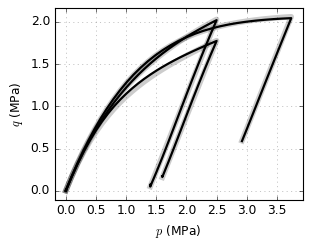

In [23]:
plt.rcParams["figure.figsize"] = (4,3)
fig = plt.figure()
ax = fig.subplots(1)
ax.margins(x=0.05, y = 0.05)
x=-1
for i in np.arange(len(ntest)):
    ax.plot(strain_t_test[:,i,1]*1e+5,stress_test[:,i,1]/c,alpha=0.2,linewidth=5,color='black',
            markersize=0,marker='.')
    ax.plot(strain_t_test[:,i,1]*1e+5,pred_stress[:,i,1].detach()/c,alpha=1,linewidth=2,color='black',
            markersize=0,marker='.')
ax.set_ylabel('$q$ (MPa)')
ax.set_xlabel('$p$ (MPa)')
ax.grid()
plt.show()
# fig.savefig(f"./pq_resB.pdf", format="pdf", transparent=True)

### 5. Inference

In [24]:
# File path for the inference dataset
file = './dataset/ideal/benchmark1_data_inference_DrainedTriaxial'

# Loading data from the specified file using pickle
with open(file, 'rb') as f_obj:
    data = pickle.load(f_obj)

# Unpacking data into individual variables
[stress_t, strain_t, svars_e_t, svars_p_t,
 stress_tdt, strain_tdt, svars_e_tdt, svars_p_tdt, _, _, dt, n_reset] = data

# Setting batch_time and data_size based on the values from the inference dataset
batch_time = n_reset
data_size = n_reset

In [25]:
# Computing the incremental stress, strain, and elastic state variables
dstress = stress_tdt - stress_t
dstrain = strain_tdt - strain_t
dsvars_e = svars_e_tdt - svars_e_t

# Scaling the incremental stress, strain, and elastic state variables by the time step
dstress /= prm_dt
dstrain /= prm_dt
dsvars_e /= prm_dt

In [26]:
# Reshaping strain, incremental strain, elastic strain, and stress data arrays for better organization
strain_t = np.reshape(strain_t, (batch_time, -1, dim), order='F')
dstrain = np.reshape(dstrain, (batch_time, -1, dim), order='F')
el_strain_t = np.reshape(svars_e_t, (batch_time, -1, dim), order='F')
stress_t = np.reshape(stress_t, (batch_time, -1, dim), order='F')

# Updating data_size based on the reshaped strain_t array
data_size = strain_t.shape[0]

# Calculating the number of initial conditions
number_IC = strain_t.shape[1]

In [27]:
# Set NICE network to inference mode
NICE_network.inference = True

# Create a time array for inference
t = torch.arange(0, prm_dt * data_size, prm_dt)

# Concatenate stress and elastic strain for input data
y = torch.cat((torch.from_numpy(np.float64(stress_t)), torch.from_numpy(np.float64(el_strain_t))), -1).to(device)

# Convert incremental strain and stress to torch tensors and move to the specified device
arg = torch.from_numpy(np.float64(dstrain)).to(device)
sigma = torch.from_numpy(np.float64(stress_t)).to(device)

In [28]:
# Initialize interpolation for incremental strain and time
NICE_network.init_interp(arg, t)

# Create an array of indices
idx = np.arange(0, arg.shape[1])

# Find initial elastic strain using root finding
sol = root(NICE_network.find_elastic_strain, args=(sigma[0].reshape(-1, 2)),
           x0=np.zeros((number_IC, dim)),
           tol=1e-12)

# Convert the result to a torch tensor
eps_e_0 = torch.from_numpy(sol.x.reshape(-1, 2))

# De-normalize the initial elastic strain
ueps_e_0 = NICE_network.DeNormalize(eps_e_0, NICE_network.prm_ee)

# Inference mode: make predictions
pred_svars, pred_stress, pred_diss = NICE_network.integrate(arg[:], ueps_e_0, t[:], idx)

# Convert predictions to NumPy arrays
pred_svars = pred_svars.cpu().detach().numpy()
pred_stress = pred_stress.cpu().detach().numpy()
pred_diss = pred_diss.cpu().detach().numpy()

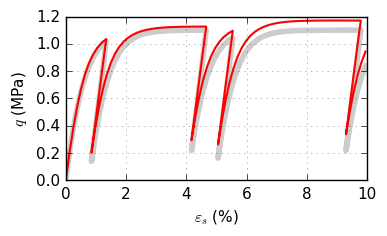

In [29]:
# Create a figure for the plot
fig = plt.figure(dpi=100, figsize=(4, 2.5), tight_layout=True)

# Create a subplot
ax = fig.subplots(1)

# Plot reference stress points against strain
for i in np.arange(5,6):
    ax.plot(strain_t[:, i, 1] * 1e+5, y[:, i, 1].cpu().detach() / 1e+3,
            marker='o', markerfacecolor='white', linestyle='-',
            color='k', alpha=0.2, linewidth=4, markersize=0, label='ref')

# Plot predicted stress points against strain
for i in np.arange(5,6):
    ax.plot(strain_t[:, i, 1] * 1e+5, pred_stress[:, i, 1] / 1e+3, alpha=1, linewidth=1.5, color='r',
            markersize=0, markeredgewidth=0.0, marker='.')

# Set labels and grid
ax.set_ylabel('$q$ (MPa)')
ax.set_xlabel('$\\varepsilon_s$ (%)')
ax.grid()
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=943eba7c-6248-4f0d-a7d4-57f7be1179ac' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>